# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

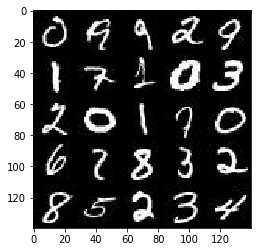

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

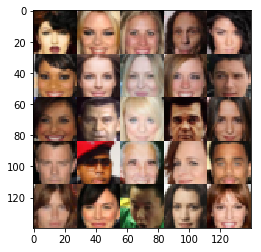

In [78]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name="inputs_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [94]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    #parameters
    kernel_size = 3
    alpha = 0.2
    
#     norm_inputs = tf.nn.l2_normalize(images,0)
    
#     print("images_shape:", images.shape)
    
    with tf.variable_scope("discriminator", reuse=reuse) as discriminator_scope:
        
        
        #input shape is 28x28x5
        input_layer1 = tf.layers.conv2d(images, 128, kernel_size, strides=2, padding='same')
        relu1 = tf.maximum(alpha * input_layer1, input_layer1) 
        #shape is now 14x14x128
        
        input_layer2 = tf.layers.conv2d(input_layer1, 256, kernel_size, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(input_layer2, training=True)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        #shape is now 7x7x256
        
#         input_layer3 = tf.layers.conv2d(input_layer2, 256, kernel_size, strides=1, padding='same')
#         batch_norm3 = tf.layers.batch_normalization(input_layer3, training=True)
#         relu3 = tf.maximum(alpha * batch_norm3, batch_norm3) 
#         shape is now 7x7x256
        
#         input_layer4 = tf.layers.conv2d(input_layer3, 512, kernel_size, strides=1, padding='same')
#         batch_norm4 = tf.layers.batch_normalization(input_layer4, training=True)
#         relu4 = tf.maximum(alpha * batch_norm4, batch_norm4) 
        
        #flatten?
#         flat = tf.reshape(relu3,(-1,28*28*256))
        flat = tf.reshape(relu2,(-1,7*7*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [93]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    kernel_size = 3
    
#     print("z.shape", z.get_shape())
    
    with tf.variable_scope('generator', reuse=not(is_train)):
#         x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.layers.dense(z,7*7*512)

        #reshape for the conv network
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
#         print("x1", x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 128,kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         print("x2", x2.get_shape())
    
        x3 = tf.layers.conv2d_transpose(x2, 64,kernel_size=3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
    
        x4 = tf.layers.conv2d_transpose(x3, 32,kernel_size=3, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
#         print("x3", x3.get_shape())

#         x5 = tf.layers.conv2d_transpose(x4, 64,kernel_size, strides=1, padding='same')
#         x5 = tf.layers.batch_normalization(x5, training=is_train)
#         x5 = tf.maximum(alpha * x5, x5)

#         x4 = tf.layers.conv2d_transpose(x3, 128,kernel_size, strides=1, padding='same')
#         x4 = tf.layers.batch_normalization(x4, training=is_train)
#         x4 = tf.maximum(alpha * x4, x4)
        
        #output
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, kernel_size, strides=1, padding='same')
#         print("logits", logits.get_shape())
        
        out = tf.tanh(logits)
        
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [58]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #implementing pattern described in deep-leraning/dcgan-svhn model_loss
    smoothing = 0.9
    
    generator_object = generator(input_z, out_channel_dim, True)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_object, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)*smoothing))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [59]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # get weights and biases variables to update
    training_variables = tf.trainable_variables()
    d_variables = [v for v in training_variables if v.name.startswith("discriminator")]
    g_variables = [v for v in training_variables if v.name.startswith("generator")]
    
    #optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_variables)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_variables)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import pickle as pkl

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    

In [79]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #model inputs
    _, img_width, img_height, img_channels = data_shape
    inputs_real, inputs_z, lr = model_inputs(img_width,img_height,img_channels, z_dim)
    #calc loss
    d_loss, g_loss = model_loss(inputs_real, inputs_z,img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    batch_count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
#                 print("batch_images shape: ", batch_images.shape)
                x = batch_images*2
                batch_count += 1
#                 print("Running epoch:",epoch_i+1, " batch: ", batch_count)
                
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: x, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: x})
                
                if(batch_count % 10 == 0):
                    train_loss_d = d_loss.eval({inputs_real: x, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.6f}...".format(train_loss_d),
                          "Generator Loss: {:.6f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if (batch_count % 100 == 0):
                    show_generator_output(sess, 25, inputs_z, img_channels, data_image_mode)
                
            saver.save(sess, './checkpoints/generator.ckpt')

    return losses

                
                

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.017523... Generator Loss: 0.271948
Epoch 1/2... Discriminator Loss: 0.784239... Generator Loss: 1.256427
Epoch 1/2... Discriminator Loss: 1.977606... Generator Loss: 0.295976
Epoch 1/2... Discriminator Loss: 1.298156... Generator Loss: 0.864622
Epoch 1/2... Discriminator Loss: 1.076276... Generator Loss: 1.077346
Epoch 1/2... Discriminator Loss: 1.016673... Generator Loss: 1.035708
Epoch 1/2... Discriminator Loss: 0.896872... Generator Loss: 1.161692
Epoch 1/2... Discriminator Loss: 0.820615... Generator Loss: 1.226567
Epoch 1/2... Discriminator Loss: 2.056492... Generator Loss: 0.407541
Epoch 1/2... Discriminator Loss: 1.792686... Generator Loss: 0.530603


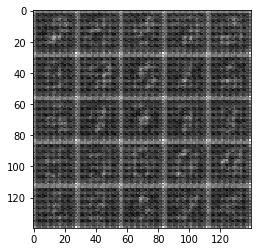

Epoch 1/2... Discriminator Loss: 1.461288... Generator Loss: 0.748116
Epoch 1/2... Discriminator Loss: 1.430899... Generator Loss: 0.721935
Epoch 1/2... Discriminator Loss: 1.404729... Generator Loss: 0.788157
Epoch 1/2... Discriminator Loss: 1.502365... Generator Loss: 0.551921
Epoch 1/2... Discriminator Loss: 1.366466... Generator Loss: 0.738538
Epoch 1/2... Discriminator Loss: 1.469447... Generator Loss: 0.745516
Epoch 1/2... Discriminator Loss: 1.472822... Generator Loss: 0.804193
Epoch 1/2... Discriminator Loss: 1.547588... Generator Loss: 0.759754
Epoch 1/2... Discriminator Loss: 1.312076... Generator Loss: 0.934136
Epoch 1/2... Discriminator Loss: 1.421068... Generator Loss: 0.652170


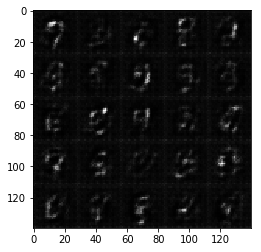

Epoch 1/2... Discriminator Loss: 1.444596... Generator Loss: 0.976442
Epoch 1/2... Discriminator Loss: 1.397053... Generator Loss: 0.770571
Epoch 1/2... Discriminator Loss: 1.539418... Generator Loss: 0.574441
Epoch 1/2... Discriminator Loss: 1.466399... Generator Loss: 0.832783
Epoch 1/2... Discriminator Loss: 1.412705... Generator Loss: 0.922075
Epoch 1/2... Discriminator Loss: 1.316587... Generator Loss: 0.708083
Epoch 1/2... Discriminator Loss: 1.349907... Generator Loss: 0.815544
Epoch 1/2... Discriminator Loss: 1.423996... Generator Loss: 0.625639
Epoch 1/2... Discriminator Loss: 1.313190... Generator Loss: 0.751079
Epoch 1/2... Discriminator Loss: 1.330475... Generator Loss: 0.767514


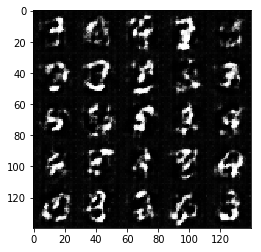

Epoch 1/2... Discriminator Loss: 1.319815... Generator Loss: 0.751307
Epoch 1/2... Discriminator Loss: 1.276254... Generator Loss: 0.839720
Epoch 1/2... Discriminator Loss: 1.324392... Generator Loss: 0.896022
Epoch 1/2... Discriminator Loss: 1.427071... Generator Loss: 0.557745
Epoch 1/2... Discriminator Loss: 1.233107... Generator Loss: 0.908454
Epoch 1/2... Discriminator Loss: 1.351385... Generator Loss: 0.832317
Epoch 1/2... Discriminator Loss: 1.414425... Generator Loss: 1.076862
Epoch 1/2... Discriminator Loss: 1.247261... Generator Loss: 0.966825
Epoch 1/2... Discriminator Loss: 1.356898... Generator Loss: 0.875087
Epoch 1/2... Discriminator Loss: 1.223387... Generator Loss: 0.807317


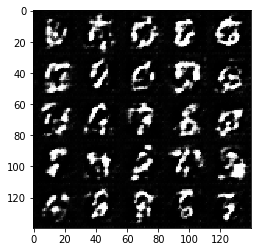

Epoch 1/2... Discriminator Loss: 1.315757... Generator Loss: 1.079919
Epoch 1/2... Discriminator Loss: 1.284999... Generator Loss: 0.758005
Epoch 1/2... Discriminator Loss: 1.331748... Generator Loss: 1.109156
Epoch 1/2... Discriminator Loss: 1.306772... Generator Loss: 0.662112
Epoch 1/2... Discriminator Loss: 1.333750... Generator Loss: 0.683983
Epoch 1/2... Discriminator Loss: 1.263358... Generator Loss: 0.962149
Epoch 1/2... Discriminator Loss: 1.245852... Generator Loss: 1.259772
Epoch 1/2... Discriminator Loss: 1.288697... Generator Loss: 0.733516
Epoch 1/2... Discriminator Loss: 1.295972... Generator Loss: 0.763395
Epoch 1/2... Discriminator Loss: 1.263116... Generator Loss: 0.891120


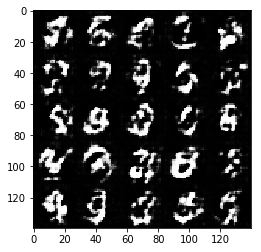

Epoch 1/2... Discriminator Loss: 1.206837... Generator Loss: 0.888980
Epoch 1/2... Discriminator Loss: 1.322161... Generator Loss: 1.015272
Epoch 1/2... Discriminator Loss: 1.268543... Generator Loss: 0.728631
Epoch 1/2... Discriminator Loss: 1.175586... Generator Loss: 0.979211
Epoch 1/2... Discriminator Loss: 1.265094... Generator Loss: 0.942529
Epoch 1/2... Discriminator Loss: 1.262393... Generator Loss: 0.714365
Epoch 1/2... Discriminator Loss: 1.206630... Generator Loss: 1.147348
Epoch 1/2... Discriminator Loss: 1.189334... Generator Loss: 0.976506
Epoch 1/2... Discriminator Loss: 1.256479... Generator Loss: 0.799616
Epoch 1/2... Discriminator Loss: 1.203617... Generator Loss: 0.965029


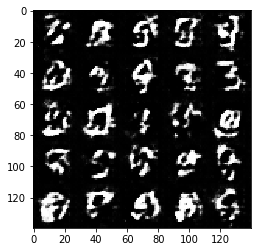

Epoch 1/2... Discriminator Loss: 1.194065... Generator Loss: 0.898176
Epoch 1/2... Discriminator Loss: 1.165420... Generator Loss: 0.845585
Epoch 1/2... Discriminator Loss: 1.222981... Generator Loss: 1.365839
Epoch 1/2... Discriminator Loss: 1.252956... Generator Loss: 0.778875
Epoch 1/2... Discriminator Loss: 1.174016... Generator Loss: 0.809259
Epoch 1/2... Discriminator Loss: 1.207776... Generator Loss: 1.147043
Epoch 1/2... Discriminator Loss: 1.176026... Generator Loss: 1.116997
Epoch 1/2... Discriminator Loss: 1.318339... Generator Loss: 0.646266
Epoch 1/2... Discriminator Loss: 1.224964... Generator Loss: 0.977912
Epoch 1/2... Discriminator Loss: 1.137785... Generator Loss: 0.835760


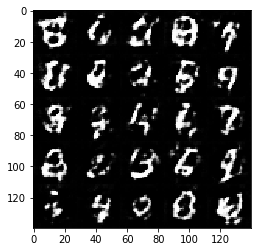

Epoch 1/2... Discriminator Loss: 1.183960... Generator Loss: 1.000510
Epoch 1/2... Discriminator Loss: 1.152106... Generator Loss: 0.843288
Epoch 1/2... Discriminator Loss: 1.102865... Generator Loss: 0.968642
Epoch 1/2... Discriminator Loss: 1.202876... Generator Loss: 0.928209
Epoch 1/2... Discriminator Loss: 1.198186... Generator Loss: 0.883875
Epoch 1/2... Discriminator Loss: 1.230910... Generator Loss: 0.750552
Epoch 1/2... Discriminator Loss: 1.186651... Generator Loss: 1.092160
Epoch 1/2... Discriminator Loss: 1.170092... Generator Loss: 0.861361
Epoch 1/2... Discriminator Loss: 1.173938... Generator Loss: 0.938568
Epoch 1/2... Discriminator Loss: 1.212097... Generator Loss: 0.939065


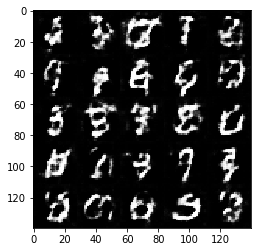

Epoch 1/2... Discriminator Loss: 1.231945... Generator Loss: 0.939823
Epoch 1/2... Discriminator Loss: 1.269964... Generator Loss: 1.294037
Epoch 1/2... Discriminator Loss: 1.216096... Generator Loss: 1.209725
Epoch 1/2... Discriminator Loss: 1.259115... Generator Loss: 0.706427
Epoch 1/2... Discriminator Loss: 1.220285... Generator Loss: 0.744674
Epoch 1/2... Discriminator Loss: 1.208028... Generator Loss: 0.741980
Epoch 1/2... Discriminator Loss: 1.199129... Generator Loss: 0.964278
Epoch 1/2... Discriminator Loss: 1.235532... Generator Loss: 0.781556
Epoch 1/2... Discriminator Loss: 1.275046... Generator Loss: 0.757806
Epoch 1/2... Discriminator Loss: 1.285556... Generator Loss: 0.826930


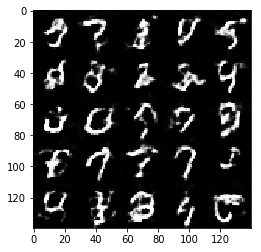

Epoch 1/2... Discriminator Loss: 1.222662... Generator Loss: 0.900995
Epoch 1/2... Discriminator Loss: 1.196415... Generator Loss: 1.058866
Epoch 1/2... Discriminator Loss: 1.244600... Generator Loss: 1.043020
Epoch 2/2... Discriminator Loss: 1.311023... Generator Loss: 0.613199
Epoch 2/2... Discriminator Loss: 1.329304... Generator Loss: 1.225411
Epoch 2/2... Discriminator Loss: 1.224533... Generator Loss: 1.126903
Epoch 2/2... Discriminator Loss: 1.261051... Generator Loss: 0.794190
Epoch 2/2... Discriminator Loss: 1.327389... Generator Loss: 1.147857
Epoch 2/2... Discriminator Loss: 1.240952... Generator Loss: 1.098554
Epoch 2/2... Discriminator Loss: 1.280984... Generator Loss: 0.885855


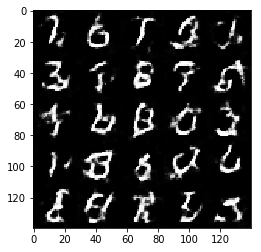

Epoch 2/2... Discriminator Loss: 1.236539... Generator Loss: 0.862999
Epoch 2/2... Discriminator Loss: 1.285643... Generator Loss: 1.034741
Epoch 2/2... Discriminator Loss: 1.283078... Generator Loss: 0.868745
Epoch 2/2... Discriminator Loss: 1.278910... Generator Loss: 0.785072
Epoch 2/2... Discriminator Loss: 1.277079... Generator Loss: 0.906485
Epoch 2/2... Discriminator Loss: 1.252280... Generator Loss: 0.850359
Epoch 2/2... Discriminator Loss: 1.286986... Generator Loss: 0.885524
Epoch 2/2... Discriminator Loss: 1.313735... Generator Loss: 0.825415
Epoch 2/2... Discriminator Loss: 1.302575... Generator Loss: 1.121030
Epoch 2/2... Discriminator Loss: 1.340391... Generator Loss: 0.821098


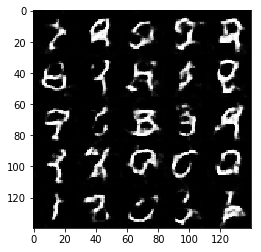

Epoch 2/2... Discriminator Loss: 1.279950... Generator Loss: 0.854943
Epoch 2/2... Discriminator Loss: 1.371282... Generator Loss: 1.092834
Epoch 2/2... Discriminator Loss: 1.319624... Generator Loss: 0.646700
Epoch 2/2... Discriminator Loss: 1.334495... Generator Loss: 0.765989
Epoch 2/2... Discriminator Loss: 1.273130... Generator Loss: 0.867986
Epoch 2/2... Discriminator Loss: 1.306856... Generator Loss: 0.867495
Epoch 2/2... Discriminator Loss: 1.310028... Generator Loss: 0.878032
Epoch 2/2... Discriminator Loss: 1.327943... Generator Loss: 0.705386
Epoch 2/2... Discriminator Loss: 1.282863... Generator Loss: 0.836330
Epoch 2/2... Discriminator Loss: 1.346688... Generator Loss: 0.838419


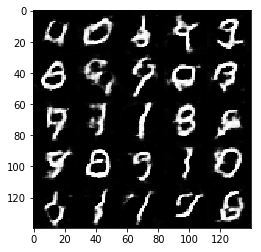

Epoch 2/2... Discriminator Loss: 1.336246... Generator Loss: 0.747374
Epoch 2/2... Discriminator Loss: 1.318382... Generator Loss: 0.831304
Epoch 2/2... Discriminator Loss: 1.435390... Generator Loss: 0.633902
Epoch 2/2... Discriminator Loss: 1.351635... Generator Loss: 0.961284
Epoch 2/2... Discriminator Loss: 1.379940... Generator Loss: 0.776897
Epoch 2/2... Discriminator Loss: 1.335646... Generator Loss: 0.853248
Epoch 2/2... Discriminator Loss: 1.351254... Generator Loss: 0.965894
Epoch 2/2... Discriminator Loss: 1.240885... Generator Loss: 0.950436
Epoch 2/2... Discriminator Loss: 1.303690... Generator Loss: 0.829888
Epoch 2/2... Discriminator Loss: 1.436417... Generator Loss: 0.641311


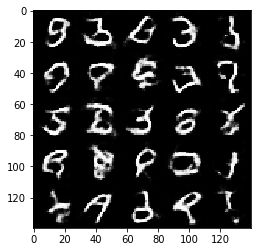

Epoch 2/2... Discriminator Loss: 1.340155... Generator Loss: 0.777995
Epoch 2/2... Discriminator Loss: 1.338934... Generator Loss: 0.760406
Epoch 2/2... Discriminator Loss: 1.342764... Generator Loss: 0.805280
Epoch 2/2... Discriminator Loss: 1.293180... Generator Loss: 0.877473
Epoch 2/2... Discriminator Loss: 1.300062... Generator Loss: 1.016950
Epoch 2/2... Discriminator Loss: 1.334571... Generator Loss: 0.999504
Epoch 2/2... Discriminator Loss: 1.382865... Generator Loss: 0.711023
Epoch 2/2... Discriminator Loss: 1.340097... Generator Loss: 0.686617
Epoch 2/2... Discriminator Loss: 1.384624... Generator Loss: 0.807628
Epoch 2/2... Discriminator Loss: 1.401898... Generator Loss: 0.927582


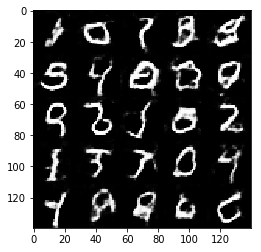

Epoch 2/2... Discriminator Loss: 1.272829... Generator Loss: 0.840723
Epoch 2/2... Discriminator Loss: 1.346281... Generator Loss: 0.994007
Epoch 2/2... Discriminator Loss: 1.356283... Generator Loss: 0.825098
Epoch 2/2... Discriminator Loss: 1.329609... Generator Loss: 0.954642
Epoch 2/2... Discriminator Loss: 1.305368... Generator Loss: 0.829875
Epoch 2/2... Discriminator Loss: 1.285352... Generator Loss: 0.883113
Epoch 2/2... Discriminator Loss: 1.330076... Generator Loss: 0.859888
Epoch 2/2... Discriminator Loss: 1.308139... Generator Loss: 0.752005
Epoch 2/2... Discriminator Loss: 1.404086... Generator Loss: 0.635616
Epoch 2/2... Discriminator Loss: 1.367833... Generator Loss: 0.752321


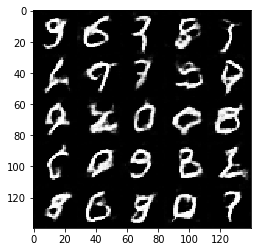

Epoch 2/2... Discriminator Loss: 1.396792... Generator Loss: 0.932266
Epoch 2/2... Discriminator Loss: 1.378448... Generator Loss: 0.977604
Epoch 2/2... Discriminator Loss: 1.397762... Generator Loss: 0.732405
Epoch 2/2... Discriminator Loss: 1.393516... Generator Loss: 0.840070
Epoch 2/2... Discriminator Loss: 1.317359... Generator Loss: 0.689548
Epoch 2/2... Discriminator Loss: 1.317167... Generator Loss: 0.721110
Epoch 2/2... Discriminator Loss: 1.352721... Generator Loss: 0.855757
Epoch 2/2... Discriminator Loss: 1.356952... Generator Loss: 0.783823
Epoch 2/2... Discriminator Loss: 1.300447... Generator Loss: 0.822781
Epoch 2/2... Discriminator Loss: 1.309651... Generator Loss: 0.798884


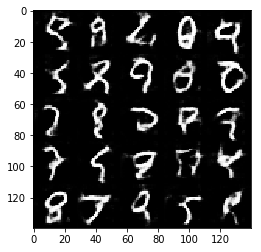

Epoch 2/2... Discriminator Loss: 1.324631... Generator Loss: 0.752116
Epoch 2/2... Discriminator Loss: 1.299994... Generator Loss: 0.909934
Epoch 2/2... Discriminator Loss: 1.336105... Generator Loss: 0.888069
Epoch 2/2... Discriminator Loss: 1.363958... Generator Loss: 0.663198
Epoch 2/2... Discriminator Loss: 1.338766... Generator Loss: 1.042735
Epoch 2/2... Discriminator Loss: 1.313055... Generator Loss: 0.745219
Epoch 2/2... Discriminator Loss: 1.294263... Generator Loss: 1.029654
Epoch 2/2... Discriminator Loss: 1.373180... Generator Loss: 0.938633
Epoch 2/2... Discriminator Loss: 1.347249... Generator Loss: 0.727574
Epoch 2/2... Discriminator Loss: 1.418171... Generator Loss: 0.695575


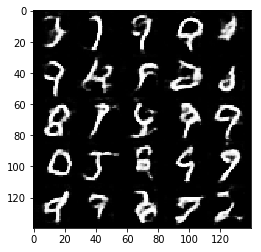

Epoch 2/2... Discriminator Loss: 1.320057... Generator Loss: 0.918988
Epoch 2/2... Discriminator Loss: 1.319577... Generator Loss: 0.928858
Epoch 2/2... Discriminator Loss: 1.375962... Generator Loss: 0.795037
Epoch 2/2... Discriminator Loss: 1.379277... Generator Loss: 0.914210
Epoch 2/2... Discriminator Loss: 1.323603... Generator Loss: 0.855662
Epoch 2/2... Discriminator Loss: 1.348908... Generator Loss: 0.776233
Epoch 2/2... Discriminator Loss: 1.326954... Generator Loss: 0.972677
Epoch 2/2... Discriminator Loss: 1.356308... Generator Loss: 0.837514
Epoch 2/2... Discriminator Loss: 1.373263... Generator Loss: 0.790282
Epoch 2/2... Discriminator Loss: 1.372598... Generator Loss: 0.754637


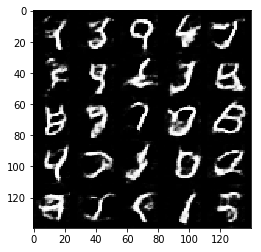

Epoch 2/2... Discriminator Loss: 1.372043... Generator Loss: 0.839032
Epoch 2/2... Discriminator Loss: 1.400744... Generator Loss: 0.740655
Epoch 2/2... Discriminator Loss: 1.321895... Generator Loss: 0.713034
Epoch 2/2... Discriminator Loss: 1.356142... Generator Loss: 0.853271
Epoch 2/2... Discriminator Loss: 1.343596... Generator Loss: 0.874077
Epoch 2/2... Discriminator Loss: 1.335847... Generator Loss: 0.932755
Epoch 2/2... Discriminator Loss: 1.362471... Generator Loss: 0.746890


In [95]:
#kernel=5, alpha=0.08, smoothing=0.9
# batch_size = 64
# z_dim = 100
# learning_rate = 0.0002
# beta1 = 0.3

#kernel=5, alpha=0.15, smoothing=0.9
# batch_size = 64
# z_dim = 100
# learning_rate = 0.0002
# beta1 = 0.4

#kernel_size=3, alpha=0.15
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

tf.reset_default_graph()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.380050... Generator Loss: 0.033736
Epoch 1/1... Discriminator Loss: 2.599751... Generator Loss: 0.230835
Epoch 1/1... Discriminator Loss: 1.969454... Generator Loss: 0.536324
Epoch 1/1... Discriminator Loss: 1.848962... Generator Loss: 0.485434
Epoch 1/1... Discriminator Loss: 1.511204... Generator Loss: 0.753665
Epoch 1/1... Discriminator Loss: 1.650091... Generator Loss: 0.779907
Epoch 1/1... Discriminator Loss: 1.440804... Generator Loss: 0.870957
Epoch 1/1... Discriminator Loss: 1.547689... Generator Loss: 0.659160
Epoch 1/1... Discriminator Loss: 1.617704... Generator Loss: 0.594059
Epoch 1/1... Discriminator Loss: 1.442084... Generator Loss: 0.792792


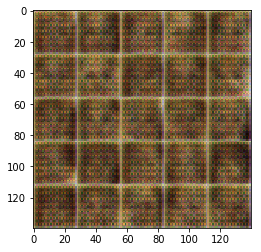

Epoch 1/1... Discriminator Loss: 1.412447... Generator Loss: 0.868336
Epoch 1/1... Discriminator Loss: 1.362883... Generator Loss: 0.823919
Epoch 1/1... Discriminator Loss: 1.270708... Generator Loss: 0.963431
Epoch 1/1... Discriminator Loss: 1.432822... Generator Loss: 0.801699
Epoch 1/1... Discriminator Loss: 1.563918... Generator Loss: 0.618997
Epoch 1/1... Discriminator Loss: 1.614958... Generator Loss: 0.645898
Epoch 1/1... Discriminator Loss: 1.529288... Generator Loss: 0.673032
Epoch 1/1... Discriminator Loss: 1.487058... Generator Loss: 0.714292
Epoch 1/1... Discriminator Loss: 1.525161... Generator Loss: 0.683890
Epoch 1/1... Discriminator Loss: 1.450119... Generator Loss: 0.821041


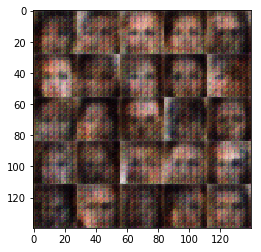

Epoch 1/1... Discriminator Loss: 1.681839... Generator Loss: 0.721606
Epoch 1/1... Discriminator Loss: 1.447473... Generator Loss: 0.769583
Epoch 1/1... Discriminator Loss: 1.432062... Generator Loss: 0.749008
Epoch 1/1... Discriminator Loss: 1.338390... Generator Loss: 0.847192
Epoch 1/1... Discriminator Loss: 1.483831... Generator Loss: 0.811200
Epoch 1/1... Discriminator Loss: 1.502023... Generator Loss: 0.731758
Epoch 1/1... Discriminator Loss: 1.424795... Generator Loss: 0.650787
Epoch 1/1... Discriminator Loss: 1.398881... Generator Loss: 0.843614
Epoch 1/1... Discriminator Loss: 1.439625... Generator Loss: 0.632230
Epoch 1/1... Discriminator Loss: 1.458346... Generator Loss: 0.801244


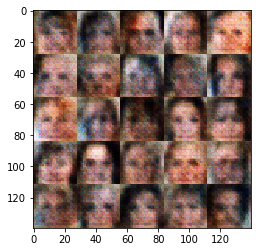

Epoch 1/1... Discriminator Loss: 1.513134... Generator Loss: 0.817954
Epoch 1/1... Discriminator Loss: 1.305832... Generator Loss: 0.784978
Epoch 1/1... Discriminator Loss: 1.531340... Generator Loss: 0.705856
Epoch 1/1... Discriminator Loss: 1.453038... Generator Loss: 0.805517
Epoch 1/1... Discriminator Loss: 1.492531... Generator Loss: 0.747640
Epoch 1/1... Discriminator Loss: 1.441299... Generator Loss: 0.788371
Epoch 1/1... Discriminator Loss: 1.534143... Generator Loss: 0.694399
Epoch 1/1... Discriminator Loss: 1.458757... Generator Loss: 0.833268
Epoch 1/1... Discriminator Loss: 1.575027... Generator Loss: 0.676536
Epoch 1/1... Discriminator Loss: 1.575614... Generator Loss: 0.617085


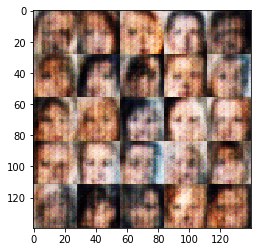

Epoch 1/1... Discriminator Loss: 1.508632... Generator Loss: 0.885023
Epoch 1/1... Discriminator Loss: 1.514903... Generator Loss: 0.646904
Epoch 1/1... Discriminator Loss: 1.419955... Generator Loss: 0.922950
Epoch 1/1... Discriminator Loss: 1.410183... Generator Loss: 0.739864
Epoch 1/1... Discriminator Loss: 1.504483... Generator Loss: 0.798010
Epoch 1/1... Discriminator Loss: 1.528819... Generator Loss: 0.869023
Epoch 1/1... Discriminator Loss: 1.496546... Generator Loss: 0.899705
Epoch 1/1... Discriminator Loss: 1.487551... Generator Loss: 0.641092
Epoch 1/1... Discriminator Loss: 1.470462... Generator Loss: 0.813703
Epoch 1/1... Discriminator Loss: 1.618446... Generator Loss: 0.590403


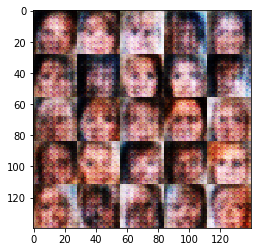

Epoch 1/1... Discriminator Loss: 1.613476... Generator Loss: 0.679229
Epoch 1/1... Discriminator Loss: 1.412111... Generator Loss: 0.904620
Epoch 1/1... Discriminator Loss: 1.447671... Generator Loss: 0.840196
Epoch 1/1... Discriminator Loss: 1.484979... Generator Loss: 0.703340
Epoch 1/1... Discriminator Loss: 1.483081... Generator Loss: 0.727771
Epoch 1/1... Discriminator Loss: 1.642318... Generator Loss: 0.663475
Epoch 1/1... Discriminator Loss: 1.560225... Generator Loss: 0.775963
Epoch 1/1... Discriminator Loss: 1.556554... Generator Loss: 0.763643
Epoch 1/1... Discriminator Loss: 1.567185... Generator Loss: 0.628312
Epoch 1/1... Discriminator Loss: 1.637972... Generator Loss: 0.663970


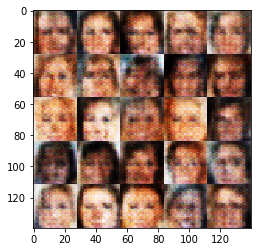

Epoch 1/1... Discriminator Loss: 1.346447... Generator Loss: 0.890270
Epoch 1/1... Discriminator Loss: 1.500754... Generator Loss: 0.706442
Epoch 1/1... Discriminator Loss: 1.629138... Generator Loss: 0.714675
Epoch 1/1... Discriminator Loss: 1.373485... Generator Loss: 0.813107
Epoch 1/1... Discriminator Loss: 1.437244... Generator Loss: 0.854411
Epoch 1/1... Discriminator Loss: 1.657784... Generator Loss: 0.620467
Epoch 1/1... Discriminator Loss: 1.440489... Generator Loss: 0.865119
Epoch 1/1... Discriminator Loss: 1.483055... Generator Loss: 0.822574
Epoch 1/1... Discriminator Loss: 1.402403... Generator Loss: 0.754855
Epoch 1/1... Discriminator Loss: 1.411857... Generator Loss: 0.909548


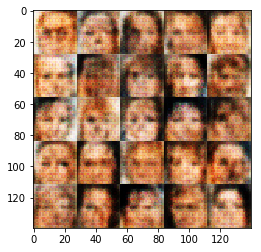

Epoch 1/1... Discriminator Loss: 1.391030... Generator Loss: 0.823284
Epoch 1/1... Discriminator Loss: 1.530171... Generator Loss: 0.705136
Epoch 1/1... Discriminator Loss: 1.525561... Generator Loss: 0.652831
Epoch 1/1... Discriminator Loss: 1.413386... Generator Loss: 0.746861
Epoch 1/1... Discriminator Loss: 1.545348... Generator Loss: 0.749879
Epoch 1/1... Discriminator Loss: 1.547957... Generator Loss: 0.671609
Epoch 1/1... Discriminator Loss: 1.484179... Generator Loss: 0.773625
Epoch 1/1... Discriminator Loss: 1.501505... Generator Loss: 0.767720
Epoch 1/1... Discriminator Loss: 1.487562... Generator Loss: 0.682138
Epoch 1/1... Discriminator Loss: 1.544188... Generator Loss: 0.752987


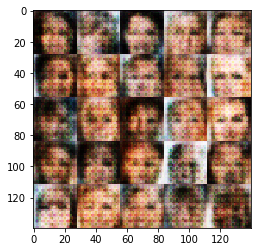

Epoch 1/1... Discriminator Loss: 1.558140... Generator Loss: 0.749847
Epoch 1/1... Discriminator Loss: 1.512623... Generator Loss: 0.668306
Epoch 1/1... Discriminator Loss: 1.443186... Generator Loss: 0.836767
Epoch 1/1... Discriminator Loss: 1.545135... Generator Loss: 0.711075
Epoch 1/1... Discriminator Loss: 1.401714... Generator Loss: 0.771261
Epoch 1/1... Discriminator Loss: 1.547060... Generator Loss: 0.673528
Epoch 1/1... Discriminator Loss: 1.515263... Generator Loss: 0.731961
Epoch 1/1... Discriminator Loss: 1.501753... Generator Loss: 0.724822
Epoch 1/1... Discriminator Loss: 1.503182... Generator Loss: 0.649666
Epoch 1/1... Discriminator Loss: 1.437956... Generator Loss: 0.760009


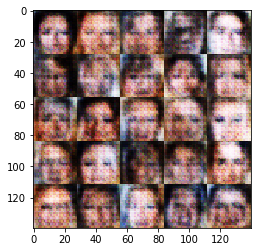

Epoch 1/1... Discriminator Loss: 1.550391... Generator Loss: 0.655766
Epoch 1/1... Discriminator Loss: 1.538373... Generator Loss: 0.700698
Epoch 1/1... Discriminator Loss: 1.334463... Generator Loss: 0.904934
Epoch 1/1... Discriminator Loss: 1.478461... Generator Loss: 0.754247
Epoch 1/1... Discriminator Loss: 1.388864... Generator Loss: 0.792517
Epoch 1/1... Discriminator Loss: 1.472516... Generator Loss: 0.723512
Epoch 1/1... Discriminator Loss: 1.486717... Generator Loss: 0.730917
Epoch 1/1... Discriminator Loss: 1.484318... Generator Loss: 0.794335
Epoch 1/1... Discriminator Loss: 1.569342... Generator Loss: 0.791702
Epoch 1/1... Discriminator Loss: 1.366413... Generator Loss: 0.938601


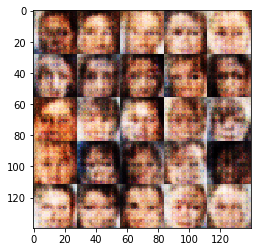

Epoch 1/1... Discriminator Loss: 1.364293... Generator Loss: 0.788172
Epoch 1/1... Discriminator Loss: 1.449887... Generator Loss: 0.700041
Epoch 1/1... Discriminator Loss: 1.534530... Generator Loss: 0.783739
Epoch 1/1... Discriminator Loss: 1.285875... Generator Loss: 0.840820
Epoch 1/1... Discriminator Loss: 1.408360... Generator Loss: 0.682090
Epoch 1/1... Discriminator Loss: 1.419326... Generator Loss: 0.689623
Epoch 1/1... Discriminator Loss: 1.308784... Generator Loss: 0.881655
Epoch 1/1... Discriminator Loss: 1.519182... Generator Loss: 0.706146
Epoch 1/1... Discriminator Loss: 1.413209... Generator Loss: 0.816268
Epoch 1/1... Discriminator Loss: 1.385181... Generator Loss: 0.894152


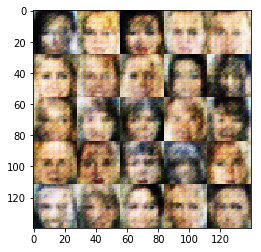

Epoch 1/1... Discriminator Loss: 1.451681... Generator Loss: 0.814281
Epoch 1/1... Discriminator Loss: 1.345864... Generator Loss: 0.840404
Epoch 1/1... Discriminator Loss: 1.345915... Generator Loss: 0.814008
Epoch 1/1... Discriminator Loss: 1.375995... Generator Loss: 0.940934
Epoch 1/1... Discriminator Loss: 1.407557... Generator Loss: 0.869438
Epoch 1/1... Discriminator Loss: 1.210618... Generator Loss: 1.123286
Epoch 1/1... Discriminator Loss: 1.336891... Generator Loss: 0.782877
Epoch 1/1... Discriminator Loss: 1.424116... Generator Loss: 0.749585
Epoch 1/1... Discriminator Loss: 1.436860... Generator Loss: 0.733092
Epoch 1/1... Discriminator Loss: 1.473813... Generator Loss: 0.685146


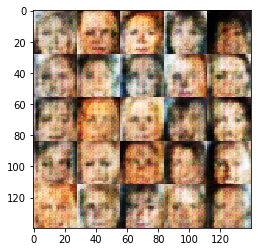

Epoch 1/1... Discriminator Loss: 1.405880... Generator Loss: 0.741597
Epoch 1/1... Discriminator Loss: 1.492587... Generator Loss: 0.780963
Epoch 1/1... Discriminator Loss: 1.140831... Generator Loss: 1.481552
Epoch 1/1... Discriminator Loss: 1.426922... Generator Loss: 0.659012
Epoch 1/1... Discriminator Loss: 1.320606... Generator Loss: 0.872864
Epoch 1/1... Discriminator Loss: 1.419896... Generator Loss: 0.691430
Epoch 1/1... Discriminator Loss: 1.358280... Generator Loss: 0.842206
Epoch 1/1... Discriminator Loss: 1.415300... Generator Loss: 0.679445
Epoch 1/1... Discriminator Loss: 1.427812... Generator Loss: 0.599864
Epoch 1/1... Discriminator Loss: 1.275271... Generator Loss: 0.909646


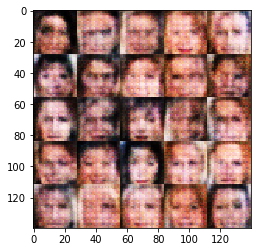

Epoch 1/1... Discriminator Loss: 1.174777... Generator Loss: 1.001151
Epoch 1/1... Discriminator Loss: 1.397888... Generator Loss: 0.789195
Epoch 1/1... Discriminator Loss: 1.236689... Generator Loss: 0.821695
Epoch 1/1... Discriminator Loss: 1.369785... Generator Loss: 0.631822
Epoch 1/1... Discriminator Loss: 1.318745... Generator Loss: 0.939896
Epoch 1/1... Discriminator Loss: 1.203273... Generator Loss: 1.468924
Epoch 1/1... Discriminator Loss: 1.186221... Generator Loss: 0.778858
Epoch 1/1... Discriminator Loss: 1.172317... Generator Loss: 0.845167
Epoch 1/1... Discriminator Loss: 1.165544... Generator Loss: 1.084197
Epoch 1/1... Discriminator Loss: 1.307852... Generator Loss: 0.629845


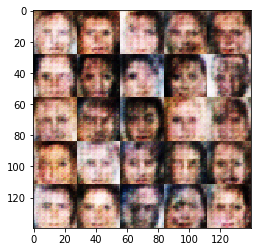

Epoch 1/1... Discriminator Loss: 1.379373... Generator Loss: 0.649913
Epoch 1/1... Discriminator Loss: 1.345988... Generator Loss: 1.195949
Epoch 1/1... Discriminator Loss: 1.032448... Generator Loss: 1.138734
Epoch 1/1... Discriminator Loss: 1.008253... Generator Loss: 1.323812
Epoch 1/1... Discriminator Loss: 1.008949... Generator Loss: 1.237946
Epoch 1/1... Discriminator Loss: 1.591053... Generator Loss: 0.419166
Epoch 1/1... Discriminator Loss: 1.136079... Generator Loss: 0.738821
Epoch 1/1... Discriminator Loss: 1.218390... Generator Loss: 1.294237
Epoch 1/1... Discriminator Loss: 1.088018... Generator Loss: 1.331406
Epoch 1/1... Discriminator Loss: 1.174168... Generator Loss: 0.832761


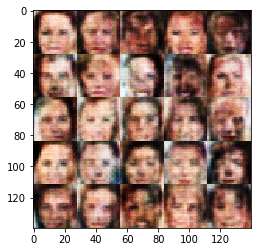

Epoch 1/1... Discriminator Loss: 1.068369... Generator Loss: 1.513509
Epoch 1/1... Discriminator Loss: 1.117404... Generator Loss: 0.983124
Epoch 1/1... Discriminator Loss: 0.898377... Generator Loss: 2.367805
Epoch 1/1... Discriminator Loss: 1.425976... Generator Loss: 0.554003
Epoch 1/1... Discriminator Loss: 1.411340... Generator Loss: 0.672694
Epoch 1/1... Discriminator Loss: 0.934331... Generator Loss: 1.568780
Epoch 1/1... Discriminator Loss: 1.280528... Generator Loss: 1.151545
Epoch 1/1... Discriminator Loss: 1.022982... Generator Loss: 0.939175
Epoch 1/1... Discriminator Loss: 0.953784... Generator Loss: 1.278745
Epoch 1/1... Discriminator Loss: 1.243267... Generator Loss: 0.706145


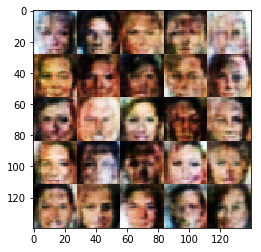

Epoch 1/1... Discriminator Loss: 0.947282... Generator Loss: 1.787668
Epoch 1/1... Discriminator Loss: 1.277160... Generator Loss: 0.939911
Epoch 1/1... Discriminator Loss: 1.414907... Generator Loss: 0.498402
Epoch 1/1... Discriminator Loss: 1.207873... Generator Loss: 1.551572
Epoch 1/1... Discriminator Loss: 1.468504... Generator Loss: 0.914881
Epoch 1/1... Discriminator Loss: 0.966501... Generator Loss: 1.239097
Epoch 1/1... Discriminator Loss: 1.079296... Generator Loss: 1.519775
Epoch 1/1... Discriminator Loss: 1.389434... Generator Loss: 1.342144
Epoch 1/1... Discriminator Loss: 0.994704... Generator Loss: 1.158157
Epoch 1/1... Discriminator Loss: 1.038721... Generator Loss: 1.053668


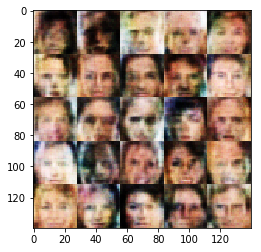

Epoch 1/1... Discriminator Loss: 1.213136... Generator Loss: 1.188946
Epoch 1/1... Discriminator Loss: 0.951360... Generator Loss: 1.589380
Epoch 1/1... Discriminator Loss: 1.037520... Generator Loss: 1.269275
Epoch 1/1... Discriminator Loss: 1.048405... Generator Loss: 1.446223
Epoch 1/1... Discriminator Loss: 1.058244... Generator Loss: 1.059662
Epoch 1/1... Discriminator Loss: 1.025162... Generator Loss: 1.219818
Epoch 1/1... Discriminator Loss: 0.869113... Generator Loss: 1.629009
Epoch 1/1... Discriminator Loss: 1.031345... Generator Loss: 1.087284
Epoch 1/1... Discriminator Loss: 0.991781... Generator Loss: 1.157534
Epoch 1/1... Discriminator Loss: 1.032072... Generator Loss: 1.262930


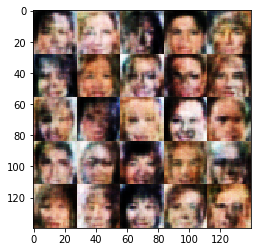

Epoch 1/1... Discriminator Loss: 0.943888... Generator Loss: 1.463998
Epoch 1/1... Discriminator Loss: 1.223095... Generator Loss: 0.751487
Epoch 1/1... Discriminator Loss: 0.988118... Generator Loss: 1.440129
Epoch 1/1... Discriminator Loss: 1.127180... Generator Loss: 0.999435
Epoch 1/1... Discriminator Loss: 0.915468... Generator Loss: 1.764414
Epoch 1/1... Discriminator Loss: 1.085775... Generator Loss: 0.866805
Epoch 1/1... Discriminator Loss: 1.547965... Generator Loss: 1.067281
Epoch 1/1... Discriminator Loss: 1.083256... Generator Loss: 0.961421
Epoch 1/1... Discriminator Loss: 1.219784... Generator Loss: 2.039992
Epoch 1/1... Discriminator Loss: 1.210534... Generator Loss: 0.920667


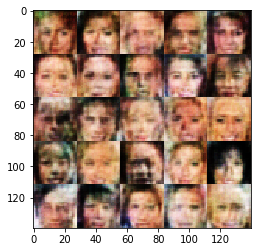

Epoch 1/1... Discriminator Loss: 1.153797... Generator Loss: 0.831923
Epoch 1/1... Discriminator Loss: 1.089937... Generator Loss: 1.394016
Epoch 1/1... Discriminator Loss: 1.045165... Generator Loss: 1.366455
Epoch 1/1... Discriminator Loss: 1.236586... Generator Loss: 0.685974
Epoch 1/1... Discriminator Loss: 1.294497... Generator Loss: 0.688384
Epoch 1/1... Discriminator Loss: 1.241012... Generator Loss: 0.835620
Epoch 1/1... Discriminator Loss: 1.132243... Generator Loss: 0.876584
Epoch 1/1... Discriminator Loss: 1.093169... Generator Loss: 0.984650
Epoch 1/1... Discriminator Loss: 1.036334... Generator Loss: 1.031688
Epoch 1/1... Discriminator Loss: 1.136436... Generator Loss: 0.908751


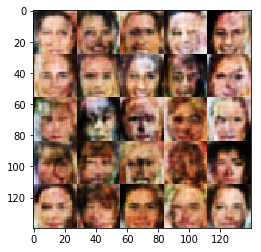

Epoch 1/1... Discriminator Loss: 1.138404... Generator Loss: 1.022505
Epoch 1/1... Discriminator Loss: 1.272745... Generator Loss: 0.682780
Epoch 1/1... Discriminator Loss: 1.441750... Generator Loss: 0.545774
Epoch 1/1... Discriminator Loss: 1.263699... Generator Loss: 0.754764
Epoch 1/1... Discriminator Loss: 0.988200... Generator Loss: 1.080865
Epoch 1/1... Discriminator Loss: 1.049504... Generator Loss: 1.620490
Epoch 1/1... Discriminator Loss: 0.856155... Generator Loss: 1.481160
Epoch 1/1... Discriminator Loss: 1.238800... Generator Loss: 1.433992
Epoch 1/1... Discriminator Loss: 1.194513... Generator Loss: 1.165798
Epoch 1/1... Discriminator Loss: 0.970621... Generator Loss: 1.377578


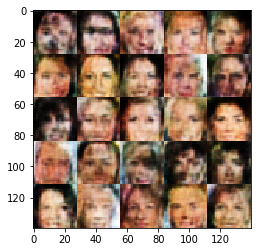

Epoch 1/1... Discriminator Loss: 1.010563... Generator Loss: 1.089913
Epoch 1/1... Discriminator Loss: 1.185683... Generator Loss: 1.534342
Epoch 1/1... Discriminator Loss: 0.889691... Generator Loss: 1.247594
Epoch 1/1... Discriminator Loss: 1.251594... Generator Loss: 1.011459
Epoch 1/1... Discriminator Loss: 1.274580... Generator Loss: 0.695596
Epoch 1/1... Discriminator Loss: 1.109786... Generator Loss: 1.095990
Epoch 1/1... Discriminator Loss: 1.124307... Generator Loss: 1.309935
Epoch 1/1... Discriminator Loss: 1.019074... Generator Loss: 1.640797
Epoch 1/1... Discriminator Loss: 1.079836... Generator Loss: 1.388440
Epoch 1/1... Discriminator Loss: 1.143266... Generator Loss: 1.474063


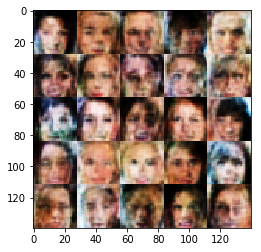

Epoch 1/1... Discriminator Loss: 0.989665... Generator Loss: 1.046585
Epoch 1/1... Discriminator Loss: 1.308153... Generator Loss: 1.043658
Epoch 1/1... Discriminator Loss: 0.988174... Generator Loss: 1.151217
Epoch 1/1... Discriminator Loss: 1.027704... Generator Loss: 1.360111
Epoch 1/1... Discriminator Loss: 1.309864... Generator Loss: 0.644428
Epoch 1/1... Discriminator Loss: 1.139321... Generator Loss: 1.021809
Epoch 1/1... Discriminator Loss: 1.156283... Generator Loss: 1.109518
Epoch 1/1... Discriminator Loss: 0.949816... Generator Loss: 1.318690
Epoch 1/1... Discriminator Loss: 1.008280... Generator Loss: 1.260296
Epoch 1/1... Discriminator Loss: 0.982455... Generator Loss: 1.248133


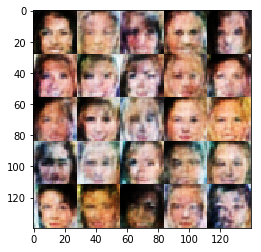

Epoch 1/1... Discriminator Loss: 0.921656... Generator Loss: 1.632871
Epoch 1/1... Discriminator Loss: 0.911451... Generator Loss: 1.236990
Epoch 1/1... Discriminator Loss: 1.078423... Generator Loss: 1.452701
Epoch 1/1... Discriminator Loss: 1.060985... Generator Loss: 0.982946
Epoch 1/1... Discriminator Loss: 1.070206... Generator Loss: 1.104027
Epoch 1/1... Discriminator Loss: 1.281910... Generator Loss: 0.587504
Epoch 1/1... Discriminator Loss: 1.319158... Generator Loss: 0.824974
Epoch 1/1... Discriminator Loss: 1.056378... Generator Loss: 1.079641
Epoch 1/1... Discriminator Loss: 1.162721... Generator Loss: 0.736986
Epoch 1/1... Discriminator Loss: 1.196294... Generator Loss: 0.817264


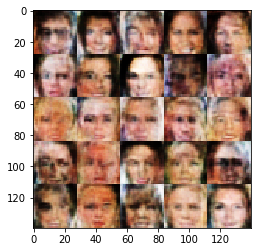

Epoch 1/1... Discriminator Loss: 1.150022... Generator Loss: 0.914480
Epoch 1/1... Discriminator Loss: 1.108759... Generator Loss: 0.912071
Epoch 1/1... Discriminator Loss: 0.990983... Generator Loss: 1.260679
Epoch 1/1... Discriminator Loss: 0.986425... Generator Loss: 1.203162
Epoch 1/1... Discriminator Loss: 1.055569... Generator Loss: 1.046503
Epoch 1/1... Discriminator Loss: 1.169838... Generator Loss: 0.860618
Epoch 1/1... Discriminator Loss: 1.082694... Generator Loss: 0.970141
Epoch 1/1... Discriminator Loss: 0.990344... Generator Loss: 1.158241
Epoch 1/1... Discriminator Loss: 0.982061... Generator Loss: 1.036080
Epoch 1/1... Discriminator Loss: 1.260095... Generator Loss: 1.107254


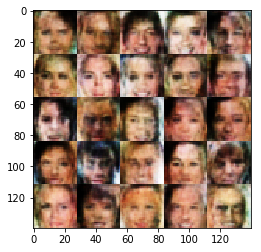

Epoch 1/1... Discriminator Loss: 0.905436... Generator Loss: 1.525247
Epoch 1/1... Discriminator Loss: 1.006865... Generator Loss: 1.465619
Epoch 1/1... Discriminator Loss: 1.120598... Generator Loss: 0.951553
Epoch 1/1... Discriminator Loss: 1.023522... Generator Loss: 1.164057
Epoch 1/1... Discriminator Loss: 1.105836... Generator Loss: 1.036275
Epoch 1/1... Discriminator Loss: 1.287506... Generator Loss: 1.044691
Epoch 1/1... Discriminator Loss: 1.101268... Generator Loss: 1.108014
Epoch 1/1... Discriminator Loss: 1.021165... Generator Loss: 1.018625
Epoch 1/1... Discriminator Loss: 1.154072... Generator Loss: 0.912588
Epoch 1/1... Discriminator Loss: 1.085891... Generator Loss: 1.044477


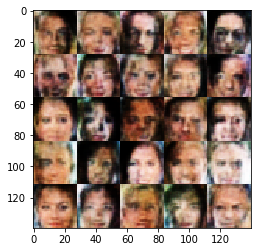

Epoch 1/1... Discriminator Loss: 1.014158... Generator Loss: 1.361053
Epoch 1/1... Discriminator Loss: 1.012754... Generator Loss: 1.532129
Epoch 1/1... Discriminator Loss: 1.069718... Generator Loss: 1.124598
Epoch 1/1... Discriminator Loss: 1.206532... Generator Loss: 0.806845
Epoch 1/1... Discriminator Loss: 1.284807... Generator Loss: 0.690567
Epoch 1/1... Discriminator Loss: 1.028370... Generator Loss: 1.078880
Epoch 1/1... Discriminator Loss: 1.021963... Generator Loss: 1.530794
Epoch 1/1... Discriminator Loss: 1.058630... Generator Loss: 1.171778
Epoch 1/1... Discriminator Loss: 0.986239... Generator Loss: 1.227620
Epoch 1/1... Discriminator Loss: 0.990008... Generator Loss: 1.137152


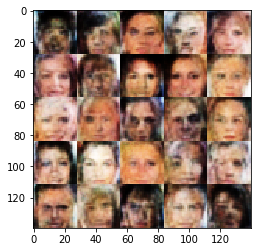

Epoch 1/1... Discriminator Loss: 1.257247... Generator Loss: 0.805915
Epoch 1/1... Discriminator Loss: 1.023708... Generator Loss: 1.484623
Epoch 1/1... Discriminator Loss: 1.342838... Generator Loss: 1.090644
Epoch 1/1... Discriminator Loss: 1.141120... Generator Loss: 1.157385
Epoch 1/1... Discriminator Loss: 1.004262... Generator Loss: 1.277261
Epoch 1/1... Discriminator Loss: 1.030758... Generator Loss: 1.027806
Epoch 1/1... Discriminator Loss: 1.161717... Generator Loss: 0.966277
Epoch 1/1... Discriminator Loss: 1.090477... Generator Loss: 0.989117
Epoch 1/1... Discriminator Loss: 1.105255... Generator Loss: 1.645907
Epoch 1/1... Discriminator Loss: 1.135117... Generator Loss: 1.197180


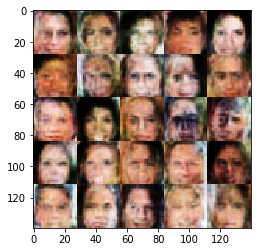

Epoch 1/1... Discriminator Loss: 1.015802... Generator Loss: 1.230654
Epoch 1/1... Discriminator Loss: 1.211493... Generator Loss: 1.266793
Epoch 1/1... Discriminator Loss: 1.100321... Generator Loss: 1.357145
Epoch 1/1... Discriminator Loss: 1.118106... Generator Loss: 1.180386
Epoch 1/1... Discriminator Loss: 1.168658... Generator Loss: 1.106130
Epoch 1/1... Discriminator Loss: 1.161491... Generator Loss: 0.952674
Epoch 1/1... Discriminator Loss: 1.088296... Generator Loss: 1.239225
Epoch 1/1... Discriminator Loss: 1.270328... Generator Loss: 0.681814
Epoch 1/1... Discriminator Loss: 1.109441... Generator Loss: 1.284029
Epoch 1/1... Discriminator Loss: 1.024106... Generator Loss: 0.958785


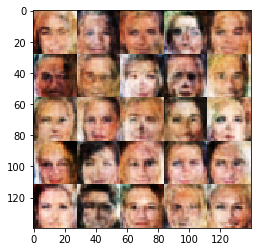

Epoch 1/1... Discriminator Loss: 0.963720... Generator Loss: 1.249100
Epoch 1/1... Discriminator Loss: 1.250514... Generator Loss: 1.525828
Epoch 1/1... Discriminator Loss: 1.177874... Generator Loss: 0.893808
Epoch 1/1... Discriminator Loss: 1.228204... Generator Loss: 0.871299
Epoch 1/1... Discriminator Loss: 1.296245... Generator Loss: 0.661195
Epoch 1/1... Discriminator Loss: 1.297549... Generator Loss: 0.625856
Epoch 1/1... Discriminator Loss: 0.967665... Generator Loss: 1.239615
Epoch 1/1... Discriminator Loss: 1.152868... Generator Loss: 1.014457
Epoch 1/1... Discriminator Loss: 1.242253... Generator Loss: 0.918477
Epoch 1/1... Discriminator Loss: 1.116120... Generator Loss: 1.427947


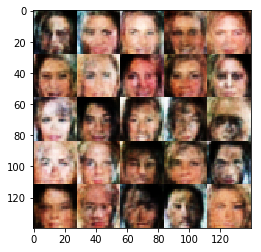

Epoch 1/1... Discriminator Loss: 1.148785... Generator Loss: 0.949383
Epoch 1/1... Discriminator Loss: 1.151361... Generator Loss: 1.194757
Epoch 1/1... Discriminator Loss: 1.227179... Generator Loss: 0.858296
Epoch 1/1... Discriminator Loss: 1.079878... Generator Loss: 0.934716
Epoch 1/1... Discriminator Loss: 1.026024... Generator Loss: 1.508011
Epoch 1/1... Discriminator Loss: 0.982544... Generator Loss: 1.050738
Epoch 1/1... Discriminator Loss: 1.190969... Generator Loss: 0.825521
Epoch 1/1... Discriminator Loss: 1.101424... Generator Loss: 1.015633
Epoch 1/1... Discriminator Loss: 1.336408... Generator Loss: 0.673764
Epoch 1/1... Discriminator Loss: 1.272617... Generator Loss: 0.787089


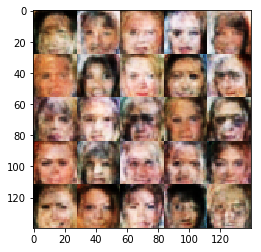

Epoch 1/1... Discriminator Loss: 1.187906... Generator Loss: 0.872898
Epoch 1/1... Discriminator Loss: 1.144845... Generator Loss: 0.949704
Epoch 1/1... Discriminator Loss: 1.305170... Generator Loss: 0.721666
Epoch 1/1... Discriminator Loss: 1.197794... Generator Loss: 0.838499
Epoch 1/1... Discriminator Loss: 1.106086... Generator Loss: 0.977489
Epoch 1/1... Discriminator Loss: 0.932651... Generator Loss: 1.324227


In [96]:
# batch_size = 128
# z_dim = 100
# learning_rate = 0.00002
# beta1 = 0.75

batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

tf.reset_default_graph()

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.